In [1]:
import time

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

import numpy as np
from torchvision import datasets, models
import pandas as pd
import cv2
import os

from typing import Callable
import torch
import torch.optim
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, CenterCrop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 256
num_epochs = 3

optimizer_factory: Callable[
    [nn.Module], torch.optim.Optimizer
] = lambda model: torch.optim.Adam(model.parameters(), lr=0.001)

resize = (32,32)

transforms = Compose(
    [   
        ToTensor(),
        # CenterCrop((480, 640)),
        Resize(resize),
        # Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # RandomRotation(1),
        # ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
        # Normalize(mean=[0.485, 0.456, 0.4], std=[0.229, 0.224, 0.2])
    ]
)

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None, device = "cpu"):
        self.df = pd.read_csv(csv_path)
        self.device = device
        self.images_folder = images_folder
        self.transform = transform
        self.img_tensor, self.label_tensor = self.load_data()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return (self.img_tensor[index], self.label_tensor[index])
    
    def load_data(self):
        # img_tensor = torch.zeros((len(self.df), num_channels, resize[0], resize[1])).to(self.device)
        # label_tensor = torch.zeros((len(self.df)))
        for i in range(len(self.df)):
            img_name = os.path.join(self.images_folder, self.df.iloc[i, 0])
            image = cv2.imread(img_name)
            label = int(self.df.iloc[i, -1])
            if self.transform:
                image = self.transform(image).to(self.device)
            if i==0:
                img_tensor = torch.unsqueeze(image, 0)
                label_tensor = [label]
                # print(label_tensor)
            else:
                img_tensor = torch.cat((img_tensor, torch.unsqueeze(image, 0)), 0)
                label_tensor.append(label)
            # print(img_tensor.shape)
        return img_tensor, torch.tensor(label_tensor).to(self.device)
    
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None, device = "cpu"):
        self.df = pd.read_csv(csv_path)
        self.device = device
        self.images_folder = images_folder
        self.transform = transform
        self.img_tensor = self.load_data()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.img_tensor[index]
    
    def load_data(self):
        for i in range(len(self.df)):
            img_name = os.path.join(self.images_folder, self.df.iloc[i, 0])
            image = cv2.imread(img_name)
            if self.transform:
                image = self.transform(image).to(self.device)
            if i==0:
                img_tensor = torch.unsqueeze(image, 0)
                # print(label_tensor)
            else:
                img_tensor = torch.cat((img_tensor, torch.unsqueeze(image, 0)), 0)
            # print(img_tensor.shape)
        return img_tensor

In [4]:
# Create the data loaders:
dataset = CustomDataset("./train.csv", "./images", transforms, "cuda")

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:

test_loader = DataLoader(CustomTestDataset("./test.csv", "./images", transforms), 
    batch_size=batch_size, shuffle=True)
# train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

/home/singroa/miniconda3/envs/cis522/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
class Model(nn.Module):
    """
    A simple CNN with 2 convolutional layers and 2 fully-connected layers.
    """

    def __init__(self, num_channels: int, num_classes: int) -> None:
        super().__init__()
        # Input = 3 x 224 x 224, Output = 16 x 224 x 224
        self.conv_layer1 = nn.Conv2d(
            in_channels=num_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        # Input = 16 x 224 x 224, Output = 16 x 224 x 224
        self.conv_layer2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        # Input = 16 x 224 x 224, Output = 16, 112, 112
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input = 16, 112, 112, Output = 32, 112, 112
        self.conv_layer3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        # Input = 32, 112, 112, Output = 32, 112, 112
        self.conv_layer4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        # Input = 32, 112, 112, Output = 32, 56, 56
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4096, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.soft = nn.Softmax()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        forward method
        """
        out = self.conv_layer1(x)
        # print(out.shape)
        out = self.relu1(out)
        out = self.conv_layer2(out)
        # print(out.shape)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.relu1(out)
        out = self.conv_layer4(out)
        
        out = self.relu1(out)
        out = self.max_pool2(out)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        # out = nn.Dropout(0.25)(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        # print(out.shape)
        # out = self.soft(out)
        # print(out.shape)
        # exit()
        return out

In [8]:
# Create the model:
model = Model(num_channels=3, num_classes=2)
# Create the optimizer:
optimizer = optimizer_factory(model)
# Create the loss function:
criterion = torch.nn.CrossEntropyLoss()
# Train the model:
tic = time.time()
num_epochs = 50
num_channels = 3
train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
# print(dataset.img_tensor.shape)
# print(dataset.label_tensor.shape)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [22]:
from sklearn.model_selection import KFold

# Move the model to the device:
# model.to(device).to(device)
model = model_ft.to(device)
train_loss_list, val_loss_list = [], []
train_acc, validation_acc = [], []
kfold = KFold(n_splits=10, shuffle=True)
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=128, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=128, sampler=test_subsampler)
    # Loop over the epochs:
    for epoch in tqdm(range(20)):
        device = "cuda"
        model.to(device)
        train_loss = 0.0
        # Set the model to training mode:
        model.train()
        # Loop over the training data:
        for x, y in train_loader:
            # Move the data to the device:
            x, y = x.to(device), y.to(device)
            # Zero the gradients:
            optimizer.zero_grad()
            # Forward pass:
            y_hat = model(x)
            # Compute the loss:
            loss = criterion(y_hat, y)
            # Backward pass:
            loss.backward()
            # Update the parameters:
            optimizer.step()
            # Calculate Loss
            train_loss += loss.item()
        train_loss_list.append(train_loss)

        device = "cpu"
        model.to(device)
        valid_loss = 0.0
        # Set the model to evaluation mode:
        model.eval()
        # Initialize the number of correct predictions:
        num_correct = 0
        total = 0
        pred = np.array([])
        # Loop over the data:
        for x, y in val_loader:
            # Move the data to the device:
            x, y = x.to(device), y.to(device)
            # Forward pass:
            y_hat = model(x)
            # Compute the predictions:
            predictions = torch.argmax(y_hat, dim=1)
            pred = np.hstack((pred, predictions.cpu()))
            loss = criterion(y_hat,y)
            valid_loss += loss.item()
            num_correct += (predictions == y).float().sum().item()
            total += len(predictions)
        val_loss_list.append(valid_loss)
        if epoch%100 == 0:
            print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
            print("acc : ", num_correct/total)
        validation_acc.append(num_correct/total)

FOLD 0
--------------------------------


  5%|▌         | 1/20 [00:38<12:16, 38.75s/it]

Epoch 1 		 Training Loss: 0.7467183048265023 		 Validation Loss: 0.7098104897886515
acc :  0.5226992351344683


100%|██████████| 20/20 [15:01<00:00, 45.09s/it]


FOLD 1
--------------------------------


  5%|▌         | 1/20 [00:47<14:54, 47.08s/it]

Epoch 1 		 Training Loss: 0.7486915370874238 		 Validation Loss: 0.7088070018216968
acc :  0.5191216382926227


100%|██████████| 20/20 [15:46<00:00, 47.31s/it]


FOLD 2
--------------------------------


  5%|▌         | 1/20 [00:47<15:06, 47.73s/it]

Epoch 1 		 Training Loss: 0.7499200153769108 		 Validation Loss: 0.705753673799336
acc :  0.5292376017764618


100%|██████████| 20/20 [15:45<00:00, 47.30s/it]


FOLD 3
--------------------------------


  5%|▌         | 1/20 [00:47<14:55, 47.12s/it]

Epoch 1 		 Training Loss: 0.7503773484313697 		 Validation Loss: 0.7061027763411403
acc :  0.5235627929928448


100%|██████████| 20/20 [15:45<00:00, 47.27s/it]


FOLD 4
--------------------------------


  5%|▌         | 1/20 [00:47<14:53, 47.03s/it]

Epoch 1 		 Training Loss: 0.7499545397465689 		 Validation Loss: 0.7160567305982113
acc :  0.501233654083395


100%|██████████| 20/20 [15:40<00:00, 47.03s/it]


FOLD 5
--------------------------------


  5%|▌         | 1/20 [00:48<15:28, 48.85s/it]

Epoch 1 		 Training Loss: 0.7460528648736184 		 Validation Loss: 0.7154741287231445
acc :  0.500740192450037


100%|██████████| 20/20 [15:49<00:00, 47.47s/it]


FOLD 6
--------------------------------


  5%|▌         | 1/20 [00:47<14:53, 47.02s/it]

Epoch 1 		 Training Loss: 0.7483282466729482 		 Validation Loss: 0.707950584590435
acc :  0.5214655810510733


100%|██████████| 20/20 [15:43<00:00, 47.16s/it]


FOLD 7
--------------------------------


  5%|▌         | 1/20 [00:47<15:07, 47.76s/it]

Epoch 1 		 Training Loss: 0.749024378207692 		 Validation Loss: 0.7084407471120358
acc :  0.5212188502343943


100%|██████████| 20/20 [15:45<00:00, 47.29s/it]


FOLD 8
--------------------------------


  5%|▌         | 1/20 [00:47<14:55, 47.12s/it]

Epoch 1 		 Training Loss: 0.75053869276716 		 Validation Loss: 0.7120125088840723
acc :  0.5170244263508512


100%|██████████| 20/20 [15:44<00:00, 47.24s/it]


FOLD 9
--------------------------------


  5%|▌         | 1/20 [00:47<14:55, 47.14s/it]

Epoch 1 		 Training Loss: 0.7483223021030426 		 Validation Loss: 0.7079760311171412
acc :  0.5198618307426598


100%|██████████| 20/20 [15:44<00:00, 47.22s/it]


In [26]:
print(predictions[:10])
print(y[:10])
len(train_loss_list)

tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0])


200

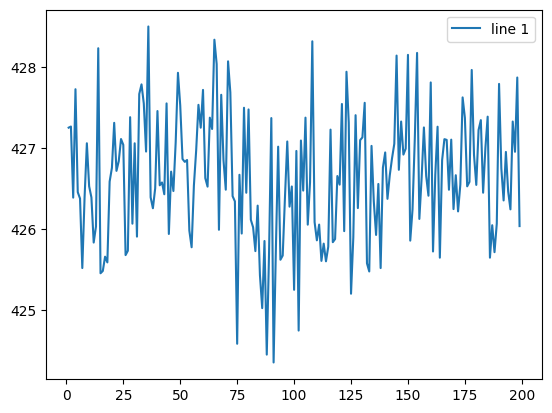

In [28]:
import matplotlib.pyplot as plt
epochs = np.arange(200)
len(train_loss_list)
# plot lines
plt.plot(epochs[1:], train_loss_list[1:], label = "line 1")
# plt.plot(epochs[1:], val_loss_list[1:], label = "line 2")
# plt.plot(epochs, validation_acc, label = "line 3")
plt.legend()
plt.show()

In [12]:
toc = time.time()
print(
    f"Training time: {toc - tic:.2f} seconds"
)
print(
    f"Training time: {(toc - tic)/60:.2f} mins"
)

Training time: 2373.54 seconds
Training time: 39.56 mins


In [29]:
# Set the model to evaluation mode:
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"
# Compute the accuracy on the test data:
model.to(device)
# Set the model to evaluation mode:
model.eval()
# Initialize the number of correct predictions:
num_correct = 0
pred = np.array([])
# Loop over the data:
for x in tqdm(test_loader):
    # Move the data to the device:
    x = x.to(device)
    # Forward pass:
    y_hat = model(x)
    # Compute the predictions:
    predictions = torch.argmax(y_hat, dim=1)
    pred = np.hstack((pred, predictions))

pred = pred.astype(int)
test_df = pd.read_csv("./test.csv")
img_path = test_df["img_path"]
df = pd.DataFrame()
df["has_under_extrusion"] = pred
df.insert(0, "img_path", img_path, True)
df.to_csv("submission.csv",index=False)

100%|██████████| 99/99 [01:31<00:00,  1.08it/s]


In [18]:
# model_names = [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [19]:
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.to("cpu")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print(dataloaders)
            print(phase)
            for inputs, labels in tqdm(dataloaders[phase]):
                print("inside")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 32

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 32

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
train, val = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
device = "cpu"
# Train and evaluate
model_ft, hist = train_model(model_ft.to(device), dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))